In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import prince  # FAMD library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
df = pd.read_csv('data/obesity_data_cleaned.csv')
df.head()

# Xác định các cột categorical và numerical
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

categorical_cols = [col for col in df.columns 
                    if col not in numerical_cols and col != 'NObeyesdad']

In [45]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Áp dụng FAMD (Factor Analysis of Mixed Data)

## Lượng phương sai giải thích theo số chiều FAMD

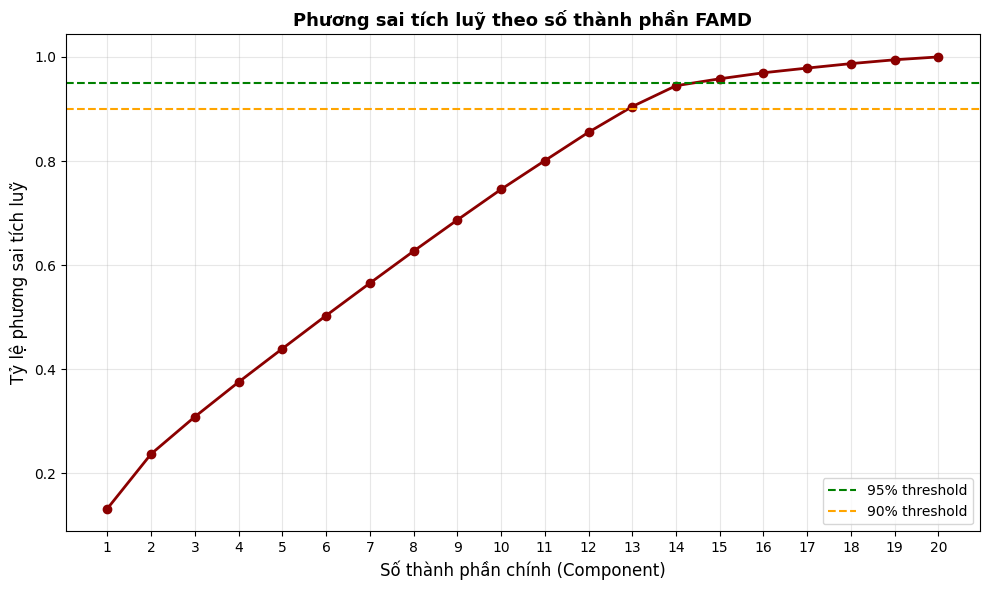

In [46]:
# Áp dụng FAMD với tất cả các components
famd_full = prince.FAMD(n_components = X.shape[1], copy=True, check_input=True, engine='sklearn', random_state=42)
famd_full.fit(X)

# Tính explained variance từ eigenvalues
explained_variance = famd_full.eigenvalues_ / famd_full.eigenvalues_.sum()
cumulative_variance = np.cumsum(explained_variance)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
        marker='o', linewidth=2, markersize=6, color='darkred')
ax.axhline(y=0.95, color='green', linestyle='--', linewidth=1.5, label='95% threshold')
ax.axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5, label='90% threshold')
ax.set_xlabel('Số thành phần chính (Component)', fontsize=12)
ax.set_ylabel('Tỷ lệ phương sai tích luỹ', fontsize=12)
ax.set_title('Phương sai tích luỹ theo số thành phần FAMD', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, len(cumulative_variance) + 1))
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

## Giảm chiều FAMD về 8 chiều

In [47]:
# FAMD về 8 chiều
famd = prince.FAMD(n_components=8, copy=True, check_input=True, engine='sklearn', random_state=42)
X_famd = famd.fit_transform(X)

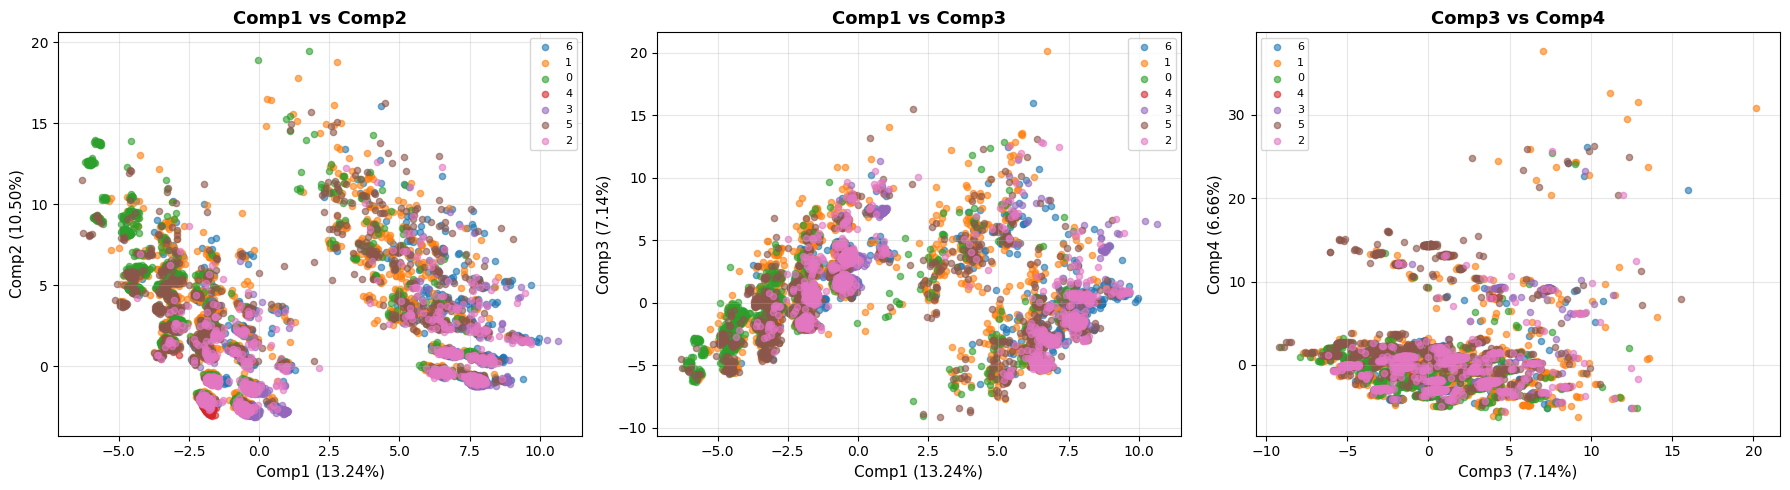

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [(0, 1), (0, 2), (2, 3)]
pair_names = [('Comp1', 'Comp2'), ('Comp1', 'Comp3'), ('Comp3', 'Comp4')]

# Tính explained variance ĐÚNG: chia cho tổng TẤT CẢ eigenvalues
total_eigenvalues = famd_full.eigenvalues_.sum()
explained_var = famd.eigenvalues_ / total_eigenvalues

# Chuyển X_famd thành numpy array để dễ indexing
X_famd_array = X_famd.values

for idx, (i, j) in enumerate(pairs):
    for label in y.unique():
        mask = y == label
        axes[idx].scatter(
            X_famd_array[mask, i], 
            X_famd_array[mask, j], 
            label=label,
            alpha=0.6, 
            s=20
        )
    axes[idx].set_xlabel(f'{pair_names[idx][0]} ({explained_var[i]:.2%})', fontsize=11)
    axes[idx].set_ylabel(f'{pair_names[idx][1]} ({explained_var[j]:.2%})', fontsize=11)
    axes[idx].set_title(f'{pair_names[idx][0]} vs {pair_names[idx][1]}', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

In [49]:
# Phương sai giải thích bởi các thành phần chính
total_eigenvalues = famd_full.eigenvalues_.sum()
explained_var = famd.eigenvalues_ / total_eigenvalues

print("Tổng phương sai giải thích bởi 8 thành phần chính:")
print(f"{explained_var.sum():.2%}")
print("\nPhương sai giải thích bởi từng thành phần:")
for i, var in enumerate(explained_var):
    print(f"Component {i+1}: {var:.2%}")

Tổng phương sai giải thích bởi 8 thành phần chính:
62.69%

Phương sai giải thích bởi từng thành phần:
Component 1: 13.24%
Component 2: 10.50%
Component 3: 7.14%
Component 4: 6.66%
Component 5: 6.41%
Component 6: 6.36%
Component 7: 6.22%
Component 8: 6.15%


In [57]:
# Lưu FAMD 8D vào file CSV
X_famd_df = X_famd.copy()
X_famd_df.columns = [f'FAMD{i+1}' for i in range(8)]
X_famd_df['NObeyesdad'] = y.values
# X_famd_df.to_csv('data/obesity_famd_8D.csv', index=False)
# print("Đã lưu FAMD 8D vào data/obesity_famd_8D.csv")
X_famd_df.head()

Đã lưu FAMD 8D vào data/obesity_famd.csv
Shape: (20758, 9)


,FAMD1,FAMD2,FAMD3,FAMD4,FAMD5,FAMD6,FAMD7,FAMD8,NObeyesdad
0,-0.570234,-2.539733,1.459931,0.769260,-0.601885,-0.314938,-0.267666,-0.774943,6
1,4.928373,4.628753,-3.134614,-3.626748,1.059261,-1.578755,3.361318,0.969037,1
2,-1.782321,-0.638735,0.698641,-3.088906,-0.062211,0.217382,1.538498,1.645419,0
3,-1.855393,-2.493690,-1.452105,-0.167419,0.440841,0.705216,-1.214091,0.182901,4
4,-0.203696,-2.673976,1.840352,0.894395,-0.651510,-0.466277,-0.228742,-1.000226,6


# LDA và trực quan

## Lượng phương sai giải thích theo số chiều LDA

In [51]:
scaler = StandardScaler()

X_lda = X.copy()
X_lda[numerical_cols] = scaler.fit_transform(X[numerical_cols])

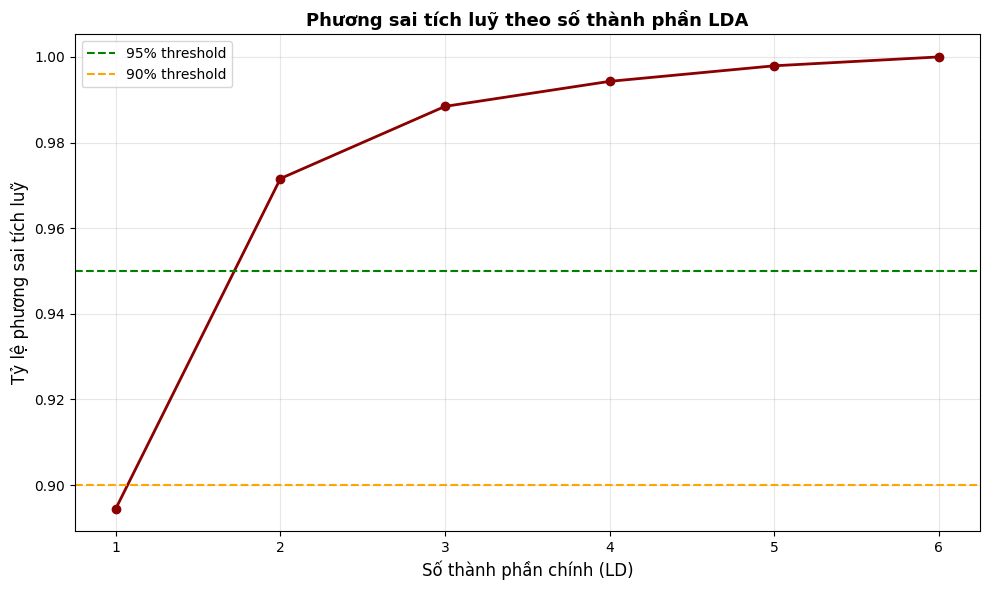

In [52]:
lda_full = LDA()
lda_full.fit(X_lda, y)

explained_variance = lda_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 
        marker='o', linewidth=2, markersize=6, color='darkred')
ax.axhline(y=0.95, color='green', linestyle='--', linewidth=1.5, label='95% threshold')
ax.axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5, label='90% threshold')
ax.set_xlabel('Số thành phần chính (LD)', fontsize=12)
ax.set_ylabel('Tỷ lệ phương sai tích luỹ', fontsize=12)
ax.set_title('Phương sai tích luỹ theo số thành phần LDA', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, len(cumulative_variance) + 1))
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

## Giảm chiều bằng LDA về 4 chiều

In [53]:
# LDA về 4 chiều
lda = LDA(n_components=4)
X_lda_4D = lda.fit_transform(X_lda, y)

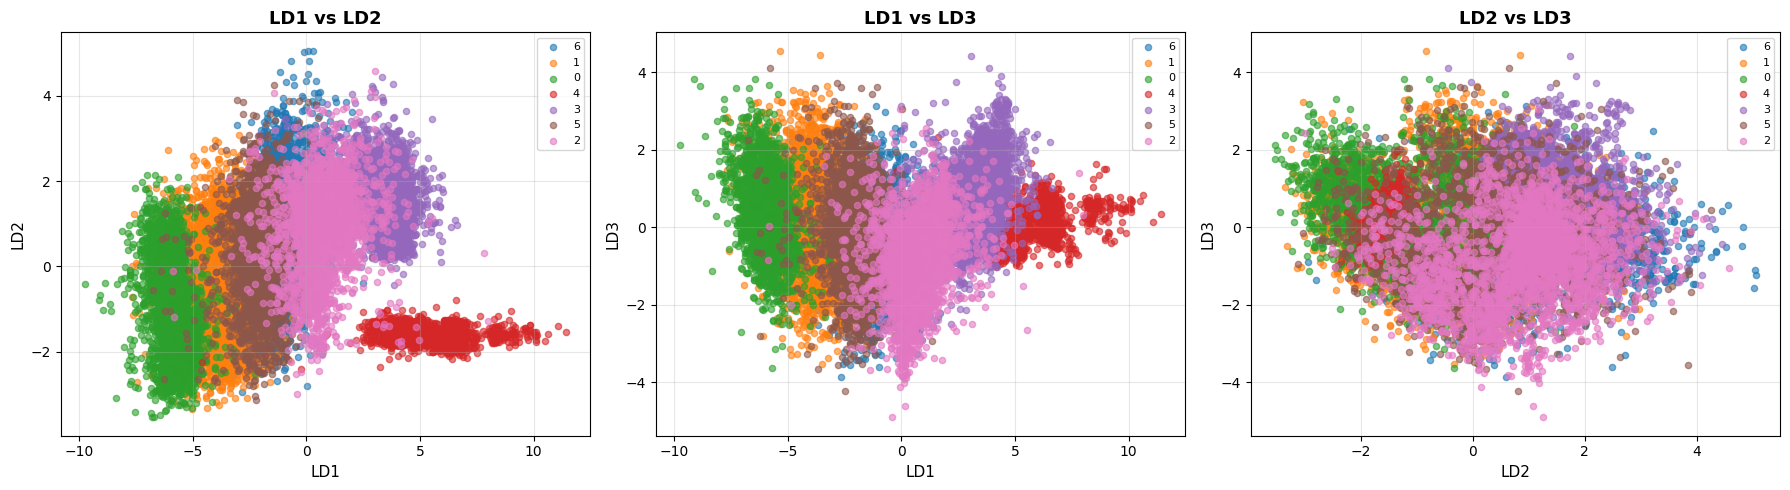

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = [(0, 1), (0, 2), (1, 2)]
pair_names = [('LD1', 'LD2'), ('LD1', 'LD3'), ('LD2', 'LD3')]

for idx, (i, j) in enumerate(pairs):
    for label in y.unique():
        mask = y == label
        axes[idx].scatter(
            X_lda_4D[mask, i], 
            X_lda_4D[mask, j], 
            label=label,
            alpha=0.6, 
            s=20
        )
    axes[idx].set_xlabel(f'{pair_names[idx][0]}', fontsize=11)
    axes[idx].set_ylabel(f'{pair_names[idx][1]}', fontsize=11)
    axes[idx].set_title(f'{pair_names[idx][0]} vs {pair_names[idx][1]}', fontsize=13, fontweight='bold')
    axes[idx].grid(alpha=0.3)
    axes[idx].legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

In [55]:
print("Tỷ lệ phương sai giải thích bởi từng thành phần LDA:")
for i, var in enumerate(lda.explained_variance_ratio_):
    print(f"LD{i+1}: {var:.2%}")
print(f"\nTổng: {lda.explained_variance_ratio_.sum():.2%}")

Tỷ lệ phương sai giải thích bởi từng thành phần LDA:
LD1: 89.45%
LD2: 7.71%
LD3: 1.69%
LD4: 0.58%

Tổng: 99.43%


In [56]:
# Lưu LDA 4D vào file CSV
X_lda_df = pd.DataFrame(X_lda_4D, columns=[f'LD{i+1}' for i in range(4)])
X_lda_df['NObeyesdad'] = y.values
# X_lda_df.to_csv('data/obesity_lda_4D.csv', index=False)
# print("Đã lưu LDA 4D vào data/obesity_lda_4D.csv")
X_lda_df.head()

Đã lưu LDA 4D vào data/obesity_lda_4D.csv


,LD1,LD2,LD3,LD4,NObeyesdad
0,-0.647815,0.823663,-0.719589,-0.549216,6
1,-4.140944,-0.874514,-2.283007,2.119023,1
2,-5.660067,-0.122093,-2.424139,0.995980,0
3,6.398418,-1.502270,0.479834,0.357482,4
4,-0.894421,1.768288,1.288060,-0.363078,6
